In [228]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import sys, os
from sklearn.model_selection import train_test_split as tts
from scipy.ndimage import uniform_filter1d
from torch.utils.data import Dataset, DataLoader, BatchSampler, SequentialSampler
import torch.nn.functional as F

sys.path.append(os.getcwd())
import models


In [229]:
# Import the keys
keys = list(np.load("keys/all_keys.npy"))
keys = [tuple(k) for k in keys]

# Import the data and labels
mi_matrices = {
    key:np.load(f"MI_matrices/MI_matrix_{key}.npy") for key in keys
}
data = {
    key:np.load(f"data/data_{key}.npy") for key in keys
}

# Sort data into a list, with the same ordering as the MI_matrices
mi_matrices_list = list()
data_list = list()
for key in keys:
    mi_matrices_list.append(mi_matrices[key])
    data_list.append(data[key])

In [240]:
# Hyperparams
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size_trn = 5
batch_size_tst = 5
learning_rate = 0.00001
num_epochs = 100
input_size = 5000
network = "CNN"
time_series = 11


In [241]:
# Numpify the data
data = np.asarray(data_list).reshape((48, 5000, 11))
labels = np.array(mi_matrices_list).reshape((48, 11, 11))

# Split the data into train and test
data_train_np, data_test_np, label_train, label_test = tts(data, labels, test_size=0.1)

# Modify variable type to tensor
data_train = models.NumbersDataset(data_train_np, label_train)
data_test = models.NumbersDataset(data_test_np, label_test)

# Create the dataloaders
loader_train = DataLoader(
    dataset=data_train, 
    sampler=BatchSampler(
        SequentialSampler(data_train), batch_size=batch_size_trn, drop_last=True
    ), 
    )

loader_test = DataLoader(
    dataset=data_test, 
    sampler=BatchSampler(
        SequentialSampler(data_test), batch_size=batch_size_tst, drop_last=True
    ), 
    )

In [242]:

data_train_np.shape, label_train.shape, data_test_np.shape, label_test.shape

((43, 5000, 11), (43, 11, 11), (5, 5000, 11), (5, 11, 11))

In [243]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.l1 = nn.Linear(input_size*11, 64)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(64, 1000)
        self.l3 = nn.Linear(1000, 11*11)

    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out


class CNN(nn.Module):
    def __init__(self, input_size, batch_size, time_series):
        super(CNN, self).__init__()
        self.out_channel = 6
        self.kernel_size = 2

        self.conv1 = nn.Conv2d(batch_size, self.out_channel, self.kernel_size)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv_size = int(self.out_channel*(input_size/self.kernel_size-1)*5)
        self.fc1 = nn.Linear(self.conv_size, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, batch_size*time_series**2)
        
        self.batch = batch_size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        xshape = int(torch.prod(torch.Tensor([x.shape])).item())
        
        x = x.view(-1, xshape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(self.batch, time_series, time_series)


In [244]:
if network == "FNN":
    model = FNN(input_size)
elif network == "CNN":
    model = CNN(input_size, batch_size_trn, time_series)
    
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
outs = []
outs_exact = []
loss_train = []
for epoch in range(num_epochs):
    outs = []
    outs_exact = []
    for i, (dat, labs) in enumerate(loader_train):
        if len(dat.shape)>3:
            dat = dat.reshape(batch_size_trn, input_size, time_series)
        if len(labs.shape)>3:
            labs = labs.reshape(batch_size_trn, time_series, time_series)

        if network == "FNN":
            batch_iter = dat.shape[0]
        
            labs = labs.reshape(batch_iter, -1).to(device)
            sample = dat.reshape(batch_iter, -1).to(device)
        else:
            labs = labs.to(device)
            sample = dat.to(device)

        # forward
        output = model(sample)
        loss = loss_func(output, labs)

        outs_exact += labs.tolist()
        outs += output.tolist()
        loss_train.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"batch {i+1} / {len(loader_train)}")
    
    if epoch % 10 == 0:
        print(f"did {epoch+1} / {num_epochs}")



did 1 / 100
did 11 / 100
did 21 / 100
did 31 / 100
did 41 / 100
did 51 / 100
did 61 / 100
did 71 / 100
did 81 / 100
did 91 / 100


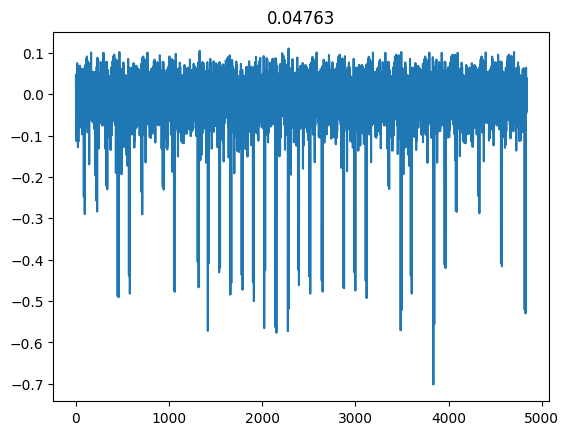

In [245]:
diff = np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1)

plt.plot(diff)
plt.title(f"{np.mean(np.abs(np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1))):.5f}")
plt.show()

In [246]:
with torch.no_grad():
    out_list = []
    label_list = []
    n_samples = 0
    n_diff = 0
    meh = []
    for dat, labs in loader_test:
        if len(dat.shape)>3:
            dat = dat.reshape(batch_size_tst, input_size, time_series)
        if len(labs.shape)>3:
            labs = labs.reshape(batch_size_tst, time_series, time_series)
        
        if network=="FNN":
            labs = labs.reshape(batch_size_tst, -1).to(device)
            sample = dat.reshape(batch_size_tst, -1).to(device)
        elif network=="CNN":
            labs = labs.to(device)
            sample = dat.to(device)

        label_list += labs.tolist()

        outputs = model(sample) # trained model
        out_list += outputs.tolist()
        n_diff += torch.mean(torch.abs(outputs-labs))
        meh += (outputs-labs).tolist()
        n_samples += 1

    acc = n_diff/n_samples

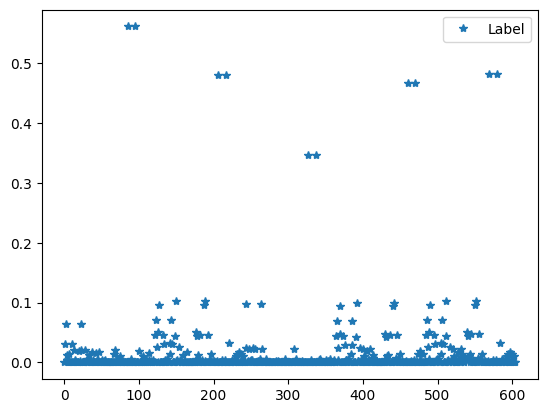

In [250]:
out_list = np.array(out_list).reshape(-1)
label_test = np.array(label_test).reshape(-1)

plt.plot(out_list, "*", label="Model output")
plt.plot(label_test, "*", label="Label")
plt.legend()
plt.show()